# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1]. Reading Data

# [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle


In [1]:
data = pd.read_csv('Reviews.csv')
print (data.head(2))
print(data.shape)

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
(568454, 10)


## [2] Data Cleaning: Deduplication and Nan features

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
#checking for Nan values in data. True indicates Nan values are present along the columns
data.isnull().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

In [3]:
# checking for Nan values along 'profilename' column
#data[data['ProfileName'].isnull()].head(2)

In [4]:
# checking for Nan values along 'summary' column
#data[data['Summary'].isnull()]

In [5]:
#Dropping Nan values
data = data.dropna()

In [6]:
#printing shape of data after dropping Nan values
print (data.shape)

(568411, 10)


In [7]:
#Review score should lie between 1 to 5
#Returns True if all the scores lie between 1 to 5(inclusive)
list1 = data['Score'].map(lambda x: True if x in [1,2,3,4,5] else False)
list1.all()

True

In [8]:
filtered_data = data.loc[data['Score']!=3].copy()
print (filtered_data.head(2))
print (filtered_data.shape)

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
(525773, 10)


In [9]:
#mapping positive(>3) and negative(<3) reviews based on scores of the data.
import pandas as pd
pos_negative = filtered_data['Score'].map(lambda x: 1 if int (x)>3  else 0)
filtered_data['Score'] = pos_negative
print ('shape of filtered_data')
print (filtered_data.shape)
#print (filtered_data.head())


shape of filtered_data
(525773, 10)


In [10]:
#arranging data with increasing productid
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort')

In [11]:
#finding the duplicates in our data
#If the same person gives for the same product at the same time we call it as suplicates
#sorted_data.loc[sorted_data.duplicated(["UserId","ProfileName","Time","Text"],keep = False),:]

In [12]:
#counting number of duplicates present in our data
sorted_data.duplicated(["UserId","ProfileName","Time","Text"]).sum()

161612

In [13]:
#dropping all duplicates keeping the first one
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace = False)
final.shape

(364161, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sorted_data['Id'].size*1.0)*100

69.26201992114468

In [15]:
#helpfulness numerator denotes number of people who found the review helpful
#helpfulness denominator denotes number of people who indicated whether or not the review helpful
#so, helpfulness numerator should be less than denominator
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#final shape of data after preprocessing
final.shape

(364159, 10)

In [17]:
final['Score'].value_counts()

1    307054
0     57105
Name: Score, dtype: int64

In [18]:
final.shape

(364159, 10)

In [19]:
#arranging data with increasing time
final_data = final.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort')

# [3] Preprocessing

# [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [120]:
#final_data = final_data.iloc[0:10000,:].copy()

In [20]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
not_words = re.findall(r'\w*n[\'|o]t',str (stop)) #finding NOT words in stop words
not_words.append('n\'t')
not_words.append('no')
print (not_words)
stop_words = stop - set (not_words)  #removing  NOT words from stop words
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r'\w*n[\'|o]t', "not", phrase)
    # general
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def cleanhtmlpunc(sentence): #function to clean the word of any html-tags
    clean = re.compile('<.*?>')
    clean = re.sub(clean, ' ', sentence)
    clean = re.sub(r"(http|www)\S+", "", clean)
    clean = re.sub(r"\S+com", "",clean)
    #clean = re.sub(r"\(\w+\)","",clean)
    clean = re.sub(r"\."," ",clean)
    cleaned = re.sub(r'[?+|!+|\'+|"+|#+|:+]',r' ',clean)
    cleantext = re.sub(r'[\.+|,+|)+|(+|\+|/+]',r' ',cleaned)
    return cleantext
#def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
   # return  cleaned
print('************************************')                 
print(stop_words)

["couldn't", "haven't", "shan't", "wouldn't", "mightn't", 'not', "don't", "weren't", "hasn't", "won't", "aren't", "wasn't", "isn't", "hadn't", "mustn't", "shouldn't", "doesn't", "didn't", "needn't", "n't", 'no']
************************************
{"you're", 'wouldn', 'does', 't', 'i', 'd', 'at', 'them', 'didn', 'a', 'when', 'we', "should've", 's', "that'll", 'but', 'if', 'did', 'up', 'are', 'haven', 'the', 'now', 'on', 'hers', 'our', 'most', 'his', 'by', 'below', 'doesn', 'as', 'with', 'aren', 'whom', 'her', 'have', 'until', 'that', 'during', 'will', 'other', 'some', 'of', 'doing', 'then', 'each', 'only', 'off', 'than', 'after', 'isn', 'and', 'can', 'where', 'what', 'should', 'against', 'couldn', 'from', 'm', 'an', 'about', 'me', 're', 'o', 'how', 'ain', 'such', 'few', 'itself', 'to', 'yourselves', 'mustn', 'own', 'themselves', 'myself', 'further', 'needn', 'their', "you'd", 'again', 'hasn', 'your', 'had', 'shouldn', 'shan', 'has', 'don', 'for', 'he', 'is', 'under', "you'll", 'just',

In [21]:
def cleanedtext(reviews):
    str1=' '
    final_string=[]
    s=''
    for sent in reviews:
        filtered_sentence=[]    
        sent=cleanhtmlpunc(decontracted(sent)) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in w.split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if((cleaned_words.lower() not in stop_words)):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words for reviews
        final_string.append(str1)
    return final_string

In [22]:
final_string = cleanedtext(final_data['Text'].values)

In [23]:
final_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
print (final_data.shape)
final_data.head(2) #below the processed review can be seen in the CleanedText Column 

(364159, 11)


Id   ProductId         UserId         ProfileName  \
150523  150524  0006641040  ACITT7DI6IDDL     shari zychinski   
150500  150501  0006641040  AJ46FKXOVC7NR  Nicholas A Mesiano   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
150523                     0                       0      1  939340800   
150500                     2                       2      1  940809600   

                                                  Summary  \
150523                          EVERY book is educational   
150500  This whole series is great way to spend time w...   

                                                     Text  \
150523  this witty little book makes my son laugh at l...   
150500  I can remember seeing the show when it aired o...   

                                              CleanedText  
150523  b'witti littl book make son laugh loud recit c...  
150500  b'rememb see show air televis year ago child s...

In [2]:
import pickle 
with open("final_data.pkl", "rb") as f:
    final_data = pickle.load(f)

In [3]:
final_data = final_data[0:5000].copy()

# 4) FEATURIZATION

In featurization we use BOW and TF-IDF, as the values in naive bayes need to positive and word2vec may contain negative values.

# (4)APPLYING AGGLOMERATIVE CLUSTERING

# 4.1) Avg W2V

In [9]:
import pickle 
with open("avg_w2v_train_data.pkl", "rb") as f:
    avg_w2v_train_data = pickle.load(f)
    

In [10]:
avg_w2v_train_data1 = avg_w2v_train_data[0:5000]

In [11]:
standardizing  = StandardScaler(with_mean = False)
avg_w2v_std_train_data = standardizing.fit_transform(avg_w2v_train_data1)
avg_w2v_std_train_data.shape

(5000, 300)

In [12]:
from sklearn.cluster import AgglomerativeClustering
aggclu = AgglomerativeClustering(n_clusters=2)
aggclu.fit(avg_w2v_std_train_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7f61680a5ae8>)

In [13]:
final_data['clusters'] = aggclu.labels_
final_data['clusters'].value_counts()

0    3971
1    1029
Name: clusters, dtype: int64

In [14]:
final_data['Score'].value_counts()

1    4422
0     578
Name: Score, dtype: int64

******************************word cloud for cluster0********************************


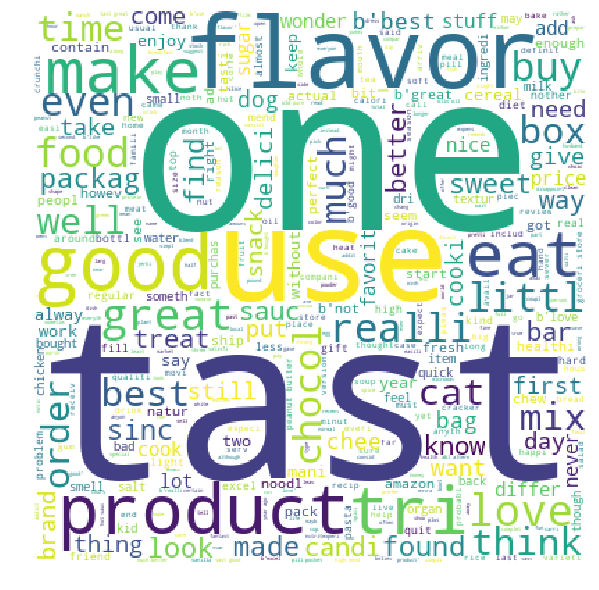

******************************word cloud for cluster1********************************


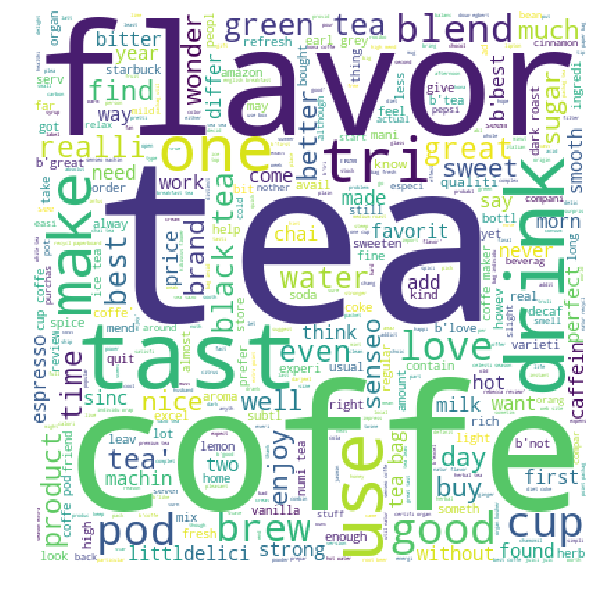

In [15]:
from wordcloud import WordCloud
for i in [0,1]:
    reviews = ''
    for review in final_data[final_data['clusters']==i]['Cleaned'].values:
        reviews = reviews + ' ' + str (review)   
    print ('******************************word cloud for cluster{0}********************************'.format(i))    
    wordcloud = WordCloud(width = 400, height = 400, 
                            background_color ='white',max_words=400).generate(reviews)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()     

In [16]:
aggclu = AgglomerativeClustering(n_clusters=5)
aggclu.fit(avg_w2v_std_train_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x7f61680a5ae8>)

In [17]:
final_data['clusters'] = aggclu.labels_
final_data['clusters'].value_counts()

0    2606
3     715
2     681
1     650
4     348
Name: clusters, dtype: int64

In [21]:
print ('num of leaves {0}'.format(aggclu.n_leaves_))
print ('num of components {0}'.format(aggclu.n_components_))

num of leaves 5000
num of components 1


******************************word cloud for cluster0********************************


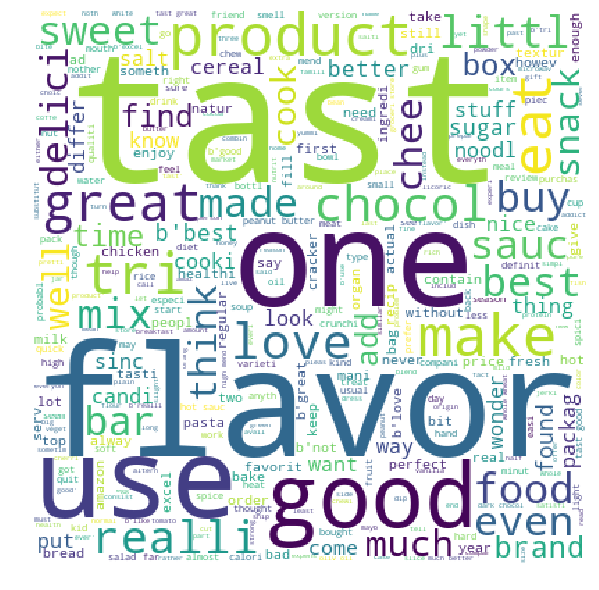

******************************word cloud for cluster3********************************


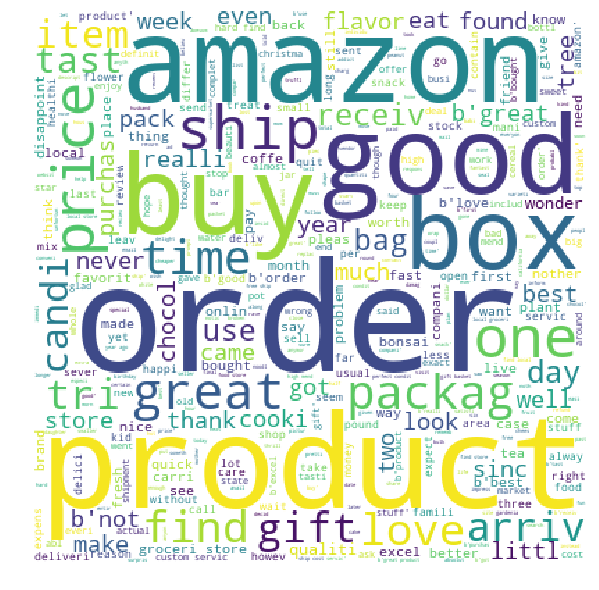

******************************word cloud for cluster2********************************


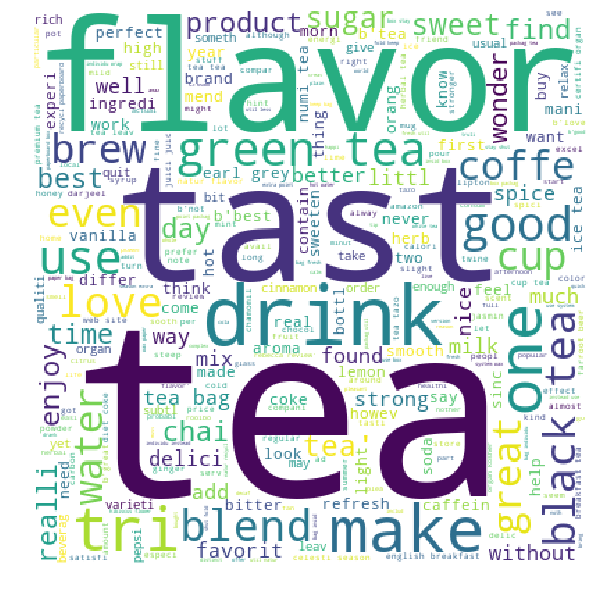

In [18]:
from wordcloud import WordCloud
for i in [0,3,2]:
    reviews = ''
    for review in final_data[final_data['clusters']==i]['Cleaned'].values:
        reviews = reviews + ' ' + str (review)   
    print ('******************************word cloud for cluster{0}********************************'.format(i))    
    wordcloud = WordCloud(width = 400, height = 400, 
                            background_color ='white',max_words=400).generate(reviews)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()     

In [23]:
aggclu = AgglomerativeClustering(n_clusters=9)
aggclu.fit(avg_w2v_std_train_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=9,
            pooling_func=<function mean at 0x7f61680a5ae8>)

In [24]:
final_data['clusters'] = aggclu.labels_
final_data['clusters'].value_counts()

0    1520
2     681
5     571
6     515
7     387
3     368
4     348
1     347
8     263
Name: clusters, dtype: int64

In [25]:
print ('num of leaves {0}'.format(aggclu.n_leaves_))
print ('num of components {0}'.format(aggclu.n_components_))

num of leaves 5000
num of components 1


******************************word cloud for cluster0********************************


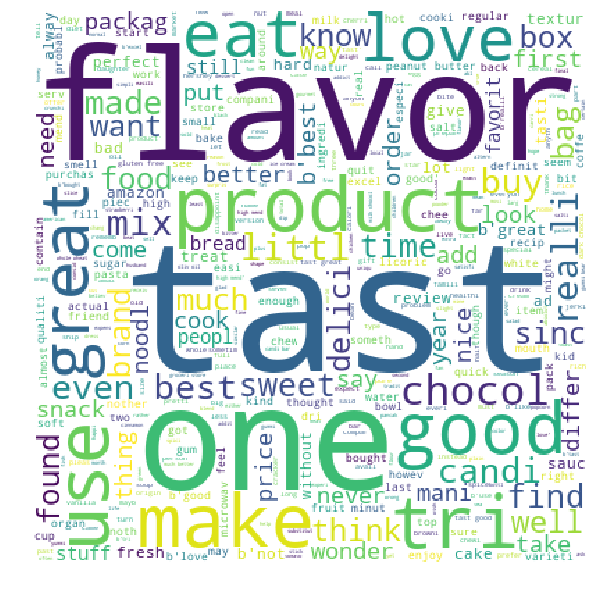

******************************word cloud for cluster2********************************


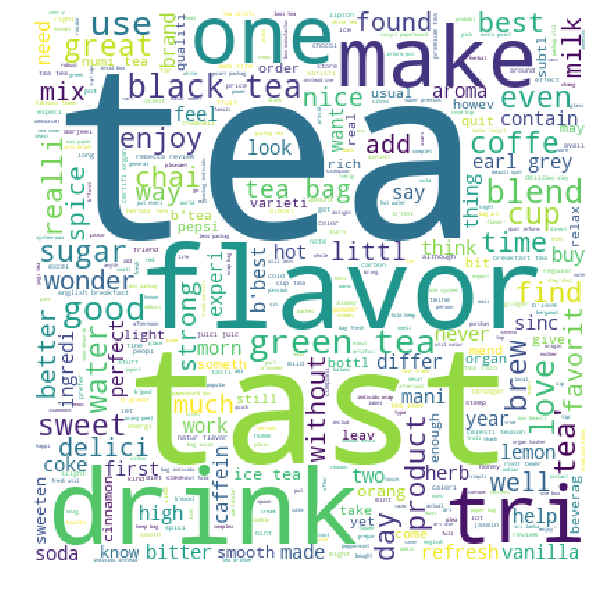

******************************word cloud for cluster5********************************


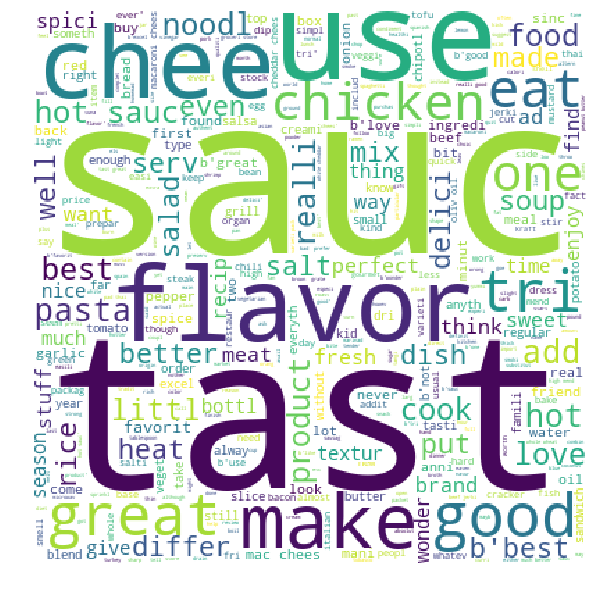

In [26]:
from wordcloud import WordCloud
for i in [0,2,5]:
    reviews = ''
    for review in final_data[final_data['clusters']==i]['Cleaned'].values:
        reviews = reviews + ' ' + str (review)   
    print ('******************************word cloud for cluster{0}********************************'.format(i))    
    wordcloud = WordCloud(width = 400, height = 400, 
                            background_color ='white',max_words=400).generate(reviews)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()     

# 4.2) TF-IDF W2V

In [27]:
import pickle 
with open("tfidf_w2v_train_data.pkl", "rb") as f:
    tfidf_w2v_train_data = pickle.load(f)
    

In [28]:
tfidf_w2v_train_data1 = tfidf_w2v_train_data[0:5000]

In [29]:
standardizing  = StandardScaler(with_mean = False)
tfidf_w2v_std_train_data = standardizing.fit_transform(tfidf_w2v_train_data1)
tfidf_w2v_std_train_data.shape

(5000, 300)

In [31]:
aggclu = AgglomerativeClustering(n_clusters=2)
aggclu.fit(tfidf_w2v_std_train_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7f61680a5ae8>)

In [32]:
final_data['clusters'] = aggclu.labels_
final_data['clusters'].value_counts()

0    4644
1     356
Name: clusters, dtype: int64

In [33]:
final_data['Score'].value_counts()

1    4422
0     578
Name: Score, dtype: int64

******************************word cloud for cluster0********************************


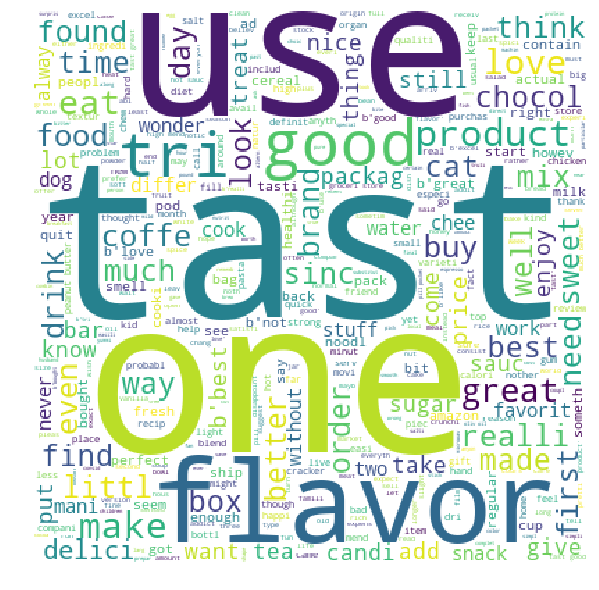

******************************word cloud for cluster1********************************


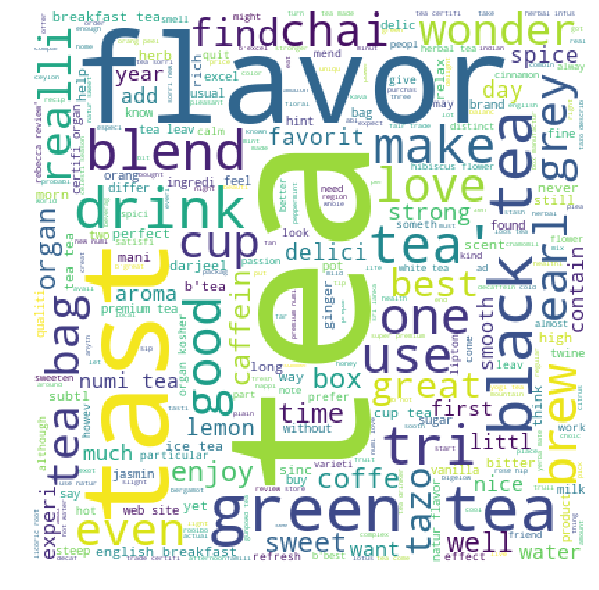

In [35]:
from wordcloud import WordCloud
for i in [0,1]:
    reviews = ''
    for review in final_data[final_data['clusters']==i]['Cleaned'].values:
        reviews = reviews + ' ' + str (review)   
    print ('******************************word cloud for cluster{0}********************************'.format(i))    
    wordcloud = WordCloud(width = 400, height = 400, 
                            background_color ='white',max_words=400).generate(reviews)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()     

In [37]:
aggclu = AgglomerativeClustering(n_clusters=12)
aggclu.fit(tfidf_w2v_std_train_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=12,
            pooling_func=<function mean at 0x7f61680a5ae8>)

In [38]:
final_data['clusters'] = aggclu.labels_
final_data['clusters'].value_counts()

0     1249
7      749
3      605
2      544
8      400
1      356
5      277
6      238
9      213
4      211
10      99
11      59
Name: clusters, dtype: int64

******************************word cloud for cluster0********************************


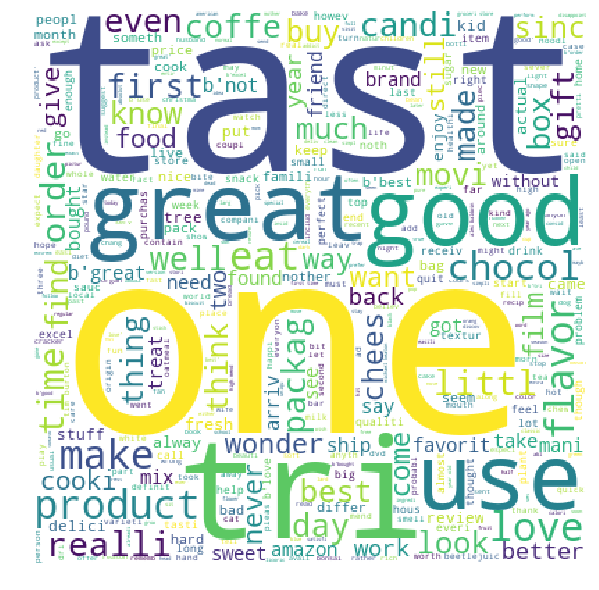

******************************word cloud for cluster7********************************


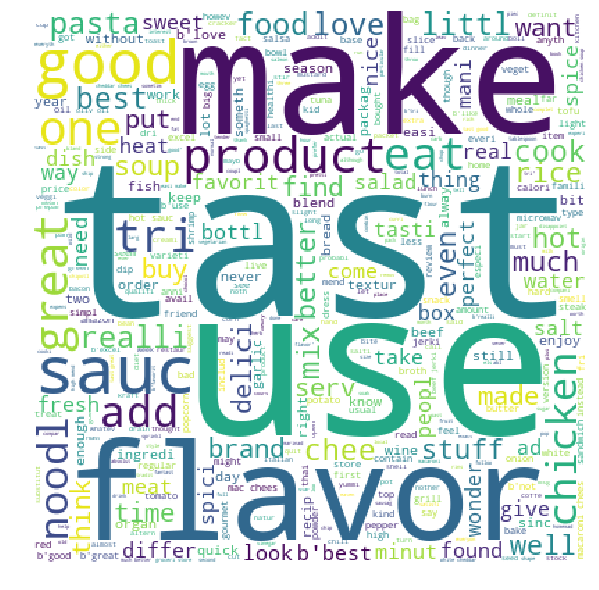

******************************word cloud for cluster3********************************


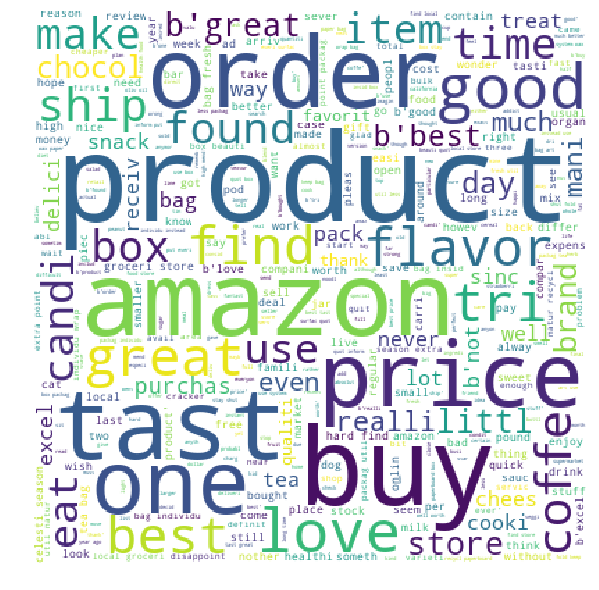

In [39]:
from wordcloud import WordCloud
for i in [0,7,3]:
    reviews = ''
    for review in final_data[final_data['clusters']==i]['Cleaned'].values:
        reviews = reviews + ' ' + str (review)   
    print ('******************************word cloud for cluster{0}********************************'.format(i))    
    wordcloud = WordCloud(width = 400, height = 400, 
                            background_color ='white',max_words=400).generate(reviews)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()     

# 5) APPLYING DBSCAN

# 5.1) AVG W2V

In [40]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.5)
dbscan.fit(avg_w2v_std_train_data)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [41]:
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4995
 0       5
Name: clusters, dtype: int64

******************************word cloud for cluster 0 ********************************


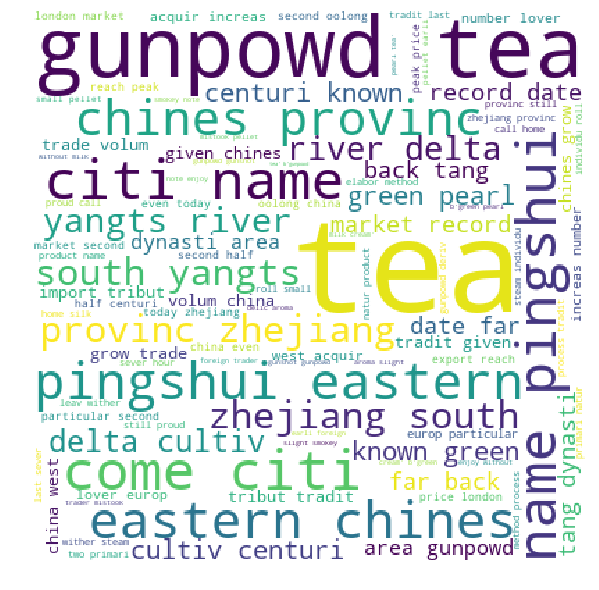

******************************word cloud for cluster -1 ********************************


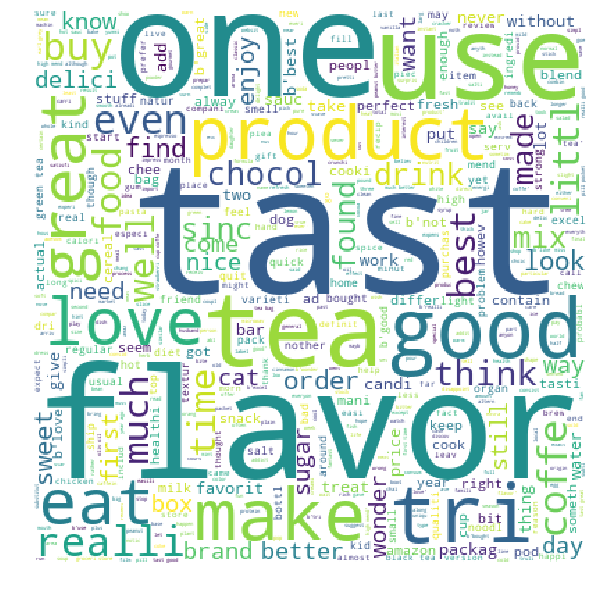

In [42]:
from wordcloud import WordCloud
for i in [0,-1]:
    reviews = ''
    for review in final_data[final_data['clusters']==i]['Cleaned'].values:
        reviews = reviews + ' ' + str (review)   
    print ('******************************word cloud for cluster {0} ********************************'.format(i))    
    wordcloud = WordCloud(width = 400, height = 400, 
                            background_color ='white',max_words=500).generate(reviews)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()     

In [43]:
dbscan = DBSCAN(eps = 1)
dbscan.fit(avg_w2v_std_train_data)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [44]:
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4990
 1       5
 0       5
Name: clusters, dtype: int64

In [45]:
dbscan = DBSCAN(eps = 4)
dbscan.fit(avg_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4980
 3       5
 2       5
 1       5
 0       5
Name: clusters, dtype: int64

In [46]:
dbscan = DBSCAN(eps = 0.05)
dbscan.fit(avg_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4995
 0       5
Name: clusters, dtype: int64

In [47]:
dbscan = DBSCAN(eps = 10)
dbscan.fit(avg_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    3344
 0    1641
 3       6
 1       6
 2       3
Name: clusters, dtype: int64

In [48]:
dbscan = DBSCAN(eps = 25)
dbscan.fit(avg_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

 0    4985
-1      15
Name: clusters, dtype: int64

# 5.2) TF-IDF W2V

In [4]:
import pickle 
with open("tfidf_w2v_train_data.pkl", "rb") as f:
    tfidf_w2v_train_data = pickle.load(f)
    
with open("tfidf_w2v_test_data.pkl", "rb") as f:
    tfidf_w2v_test_data = pickle.load(f)    

In [5]:
tfidf_w2v_train_data1 = tfidf_w2v_train_data[0:5000]

In [6]:
standardizing  = StandardScaler(with_mean = False)
tfidf_w2v_std_train_data = standardizing.fit_transform(tfidf_w2v_train_data1)
tfidf_w2v_std_train_data.shape

(5000, 300)

In [9]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.005)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4995
 0       5
Name: clusters, dtype: int64

In [10]:
dbscan = DBSCAN(eps = 0.05)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4995
 0       5
Name: clusters, dtype: int64

In [11]:
dbscan = DBSCAN(eps = 0.5)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4995
 0       5
Name: clusters, dtype: int64

In [12]:
dbscan = DBSCAN(eps = 5)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4903
 0      77
 3       5
 2       5
 1       5
 4       5
Name: clusters, dtype: int64

In [13]:
dbscan = DBSCAN(eps = 50)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

0    5000
Name: clusters, dtype: int64

In [15]:
dbscan = DBSCAN(eps =0.5,min_samples=5)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4995
 0       5
Name: clusters, dtype: int64

In [16]:
dbscan = DBSCAN(eps =15,min_samples=5)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

 0    4684
-1     316
Name: clusters, dtype: int64

In [18]:
dbscan = DBSCAN(eps =5,min_samples=5)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4903
 0      77
 3       5
 2       5
 1       5
 4       5
Name: clusters, dtype: int64

In [17]:
dbscan = DBSCAN(eps =100,min_samples=10)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

0    5000
Name: clusters, dtype: int64

In [20]:
dbscan = DBSCAN(eps =5,min_samples=5)
dbscan.fit(tfidf_w2v_std_train_data)
final_data['clusters'] = dbscan.labels_
final_data['clusters'].value_counts()

-1    4903
 0      77
 3       5
 2       5
 1       5
 4       5
Name: clusters, dtype: int64

******************************word cloud for cluster 0 ********************************


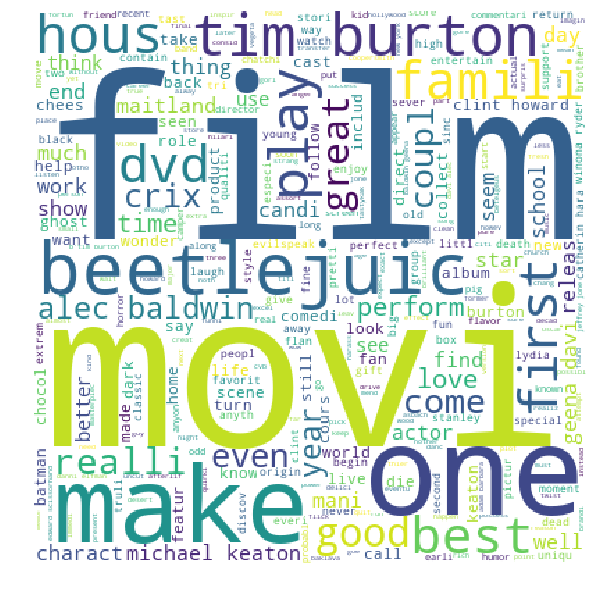

******************************word cloud for cluster 1 ********************************


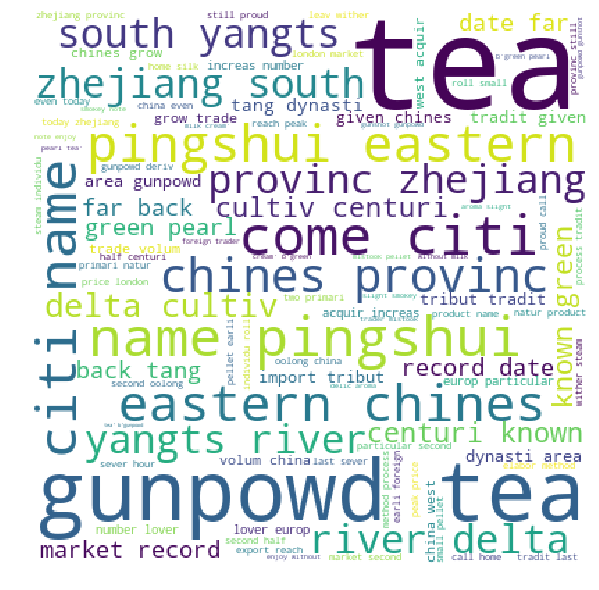

******************************word cloud for cluster 2 ********************************


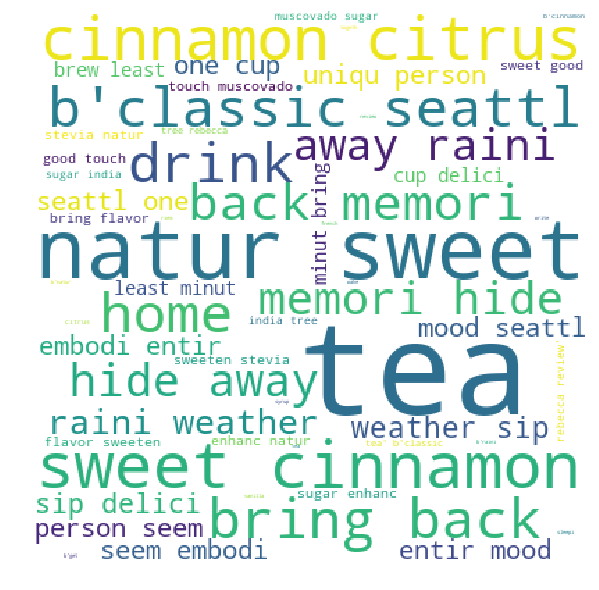

******************************word cloud for cluster 3 ********************************


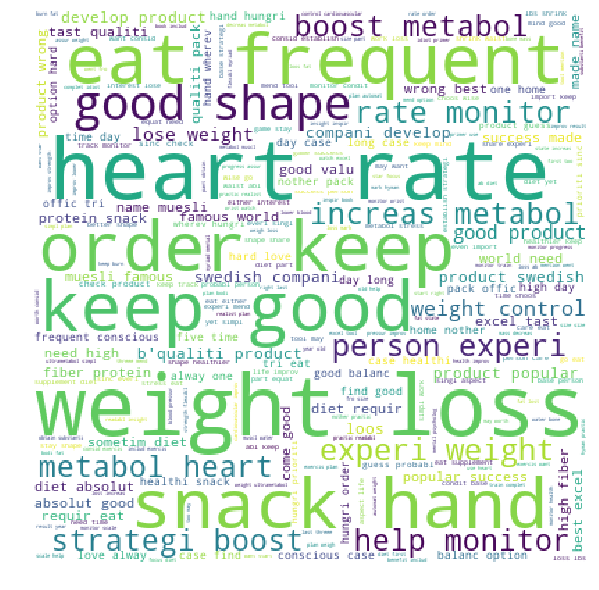

******************************word cloud for cluster 4 ********************************


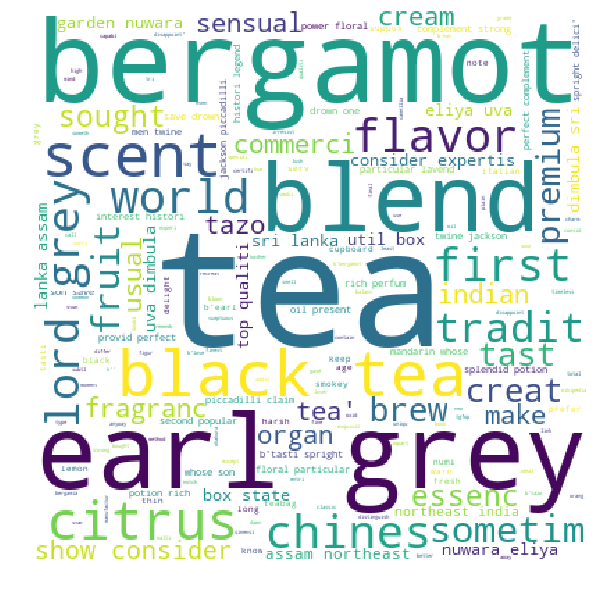

In [21]:
from wordcloud import WordCloud
for i in [0,1,2,3,4]:
    reviews = ''
    for review in final_data[final_data['clusters']==i]['Cleaned'].values:
        reviews = reviews + ' ' + str (review)   
    print ('******************************word cloud for cluster {0} ********************************'.format(i))    
    wordcloud = WordCloud(width = 400, height = 400, 
                            background_color ='white',max_words=400).generate(reviews)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()     